<a href="https://colab.research.google.com/github/mohmaed7777/Novozymes-Enzyme-Stability-Prediction/blob/main/novozyme_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c novozymes-enzyme-stability-prediction

 99% 7.00M/7.06M [00:00<00:00, 13.7MB/s]
100% 7.06M/7.06M [00:00<00:00, 9.80MB/s]


In [6]:
! unzip novozymes-enzyme-stability-prediction.zip


Archive:  novozymes-enzyme-stability-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: train_updates_20220929.csv  
  inflating: wildtype_structure_prediction_af2.pdb  


In [7]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import missingno as msno 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
print('here we go!!')


here we go!!


In [8]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_sample = pd.read_csv('/content/sample_submission.csv')

In [9]:
! pip install biopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 878 kB 14.0 MB/s 


In [10]:
from biopandas.pdb import PandasPdb
df_pdb = PandasPdb().read_pdb('/content/wildtype_structure_prediction_af2.pdb')


In [13]:
display(df_pdb)

In [14]:
type(df_pdb), df_pdb.df.keys(), df_pdb.df.items()

(biopandas.pdb.pandas_pdb.PandasPdb,
 dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS']),
 dict_items([('ATOM',      record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
 0           ATOM            1                 N                  VAL           
 1           ATOM            2                 H                  VAL           
 2           ATOM            3                H2                  VAL           
 3           ATOM            4                H3                  VAL           
 4           ATOM            5                CA                  VAL           
 ...          ...          ...     ...       ...     ...          ...     ...   
 3312        ATOM         3313                NZ                  LYS           
 3313        ATOM         3314               HZ1                  LYS           
 3314        ATOM         3315               HZ2                  LYS           
 3315        ATOM         3316               HZ3                  LYS           

In [15]:
df_atom = df_pdb.df['ATOM']
df_atom.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,VAL,,A,1,,...,34.064,-6.456,50.464,1.0,45.11,,,N,NaN,0
1,ATOM,2,,H,,VAL,,A,1,,...,33.576,-6.009,51.228,1.0,45.11,,,H,NaN,1
2,ATOM,3,,H2,,VAL,,A,1,,...,33.882,-7.449,50.477,1.0,45.11,,,H,NaN,2
3,ATOM,4,,H3,,VAL,,A,1,,...,35.060,-6.323,50.566,1.0,45.11,,,H,NaN,3
4,ATOM,5,,CA,,VAL,,A,1,,...,33.643,-5.877,49.162,1.0,45.11,,,C,NaN,4


In [16]:
df_atom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3317 entries, 0 to 3316
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   record_name     3317 non-null   object 
 1   atom_number     3317 non-null   int64  
 2   blank_1         3317 non-null   object 
 3   atom_name       3317 non-null   object 
 4   alt_loc         3317 non-null   object 
 5   residue_name    3317 non-null   object 
 6   blank_2         3317 non-null   object 
 7   chain_id        3317 non-null   object 
 8   residue_number  3317 non-null   int64  
 9   insertion       3317 non-null   object 
 10  blank_3         3317 non-null   object 
 11  x_coord         3317 non-null   float64
 12  y_coord         3317 non-null   float64
 13  z_coord         3317 non-null   float64
 14  occupancy       3317 non-null   float64
 15  b_factor        3317 non-null   float64
 16  blank_4         3317 non-null   object 
 17  segment_id      3317 non-null   o

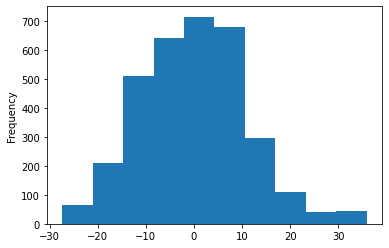

In [19]:
df_atom['x_coord'].plot(kind='hist')

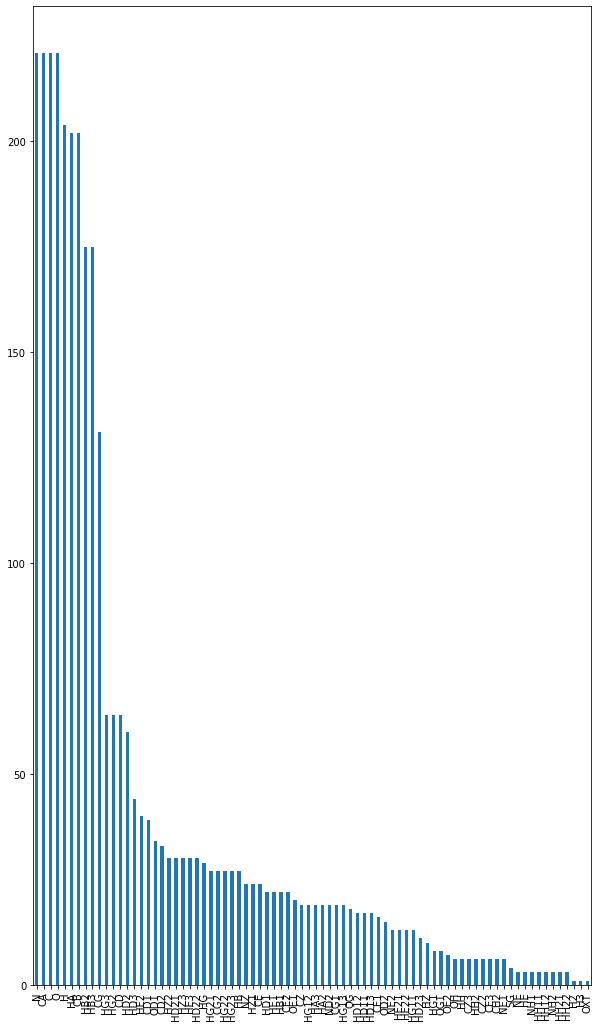

In [20]:
df_atom['atom_name'].value_counts().plot(kind='bar', figsize=(10, 18))

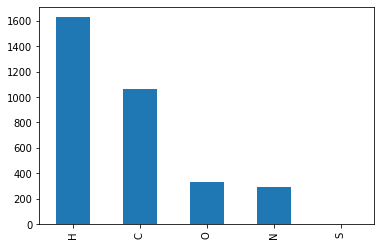

In [22]:
df_atom['element_symbol'].value_counts().plot(kind='bar')

In [23]:
df_sample.head()

,seq_id,tm
0,31390,0
1,31391,1
2,31392,2
3,31393,3
4,31394,4


In [24]:
df_train.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [25]:
df_train.isna().sum()

seq_id                 0
protein_sequence       0
pH                   286
data_source         3347
tm                     0
dtype: int64

In [26]:
df_test.head()

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [27]:
df_test.isna().sum()

seq_id              0
protein_sequence    0
pH                  0
data_source         0
dtype: int64

In [28]:
df_train.describe()

,seq_id,pH,tm
count,31390.000000,31104.000000,31390.000000
mean,15694.500000,6.892339,49.147337
std,9061.656811,1.612225,14.010089
min,0.000000,1.990000,-1.000000
25%,7847.250000,7.000000,42.100000
50%,15694.500000,7.000000,48.000000
75%,23541.750000,7.000000,53.800000
max,31389.000000,64.900000,130.000000


In [29]:
df_test.describe()

,seq_id,pH
count,2413.000000,2413.0
mean,32596.000000,8.0
std,696.717422,0.0
min,31390.000000,8.0
25%,31993.000000,8.0
50%,32596.000000,8.0
75%,33199.000000,8.0
max,33802.000000,8.0


In [31]:
cat_columns = df_train.select_dtypes(['object']).columns

In [32]:
df_train[cat_columns] = df_train[cat_columns].apply(lambda x: pd.factorize(x)[0])
cat_columns

Index(['protein_sequence', 'data_source'], dtype='object')

In [33]:
df_train

,seq_id,protein_sequence,pH,data_source,tm
0,0,0,7.0,0,75.7
1,1,1,7.0,0,50.5
2,2,2,7.0,0,40.5
3,3,3,7.0,0,47.2
4,4,4,7.0,0,49.5
...,...,...,...,...,...
31385,31385,28976,7.0,0,51.8
31386,31386,28977,7.0,0,37.2
31387,31387,28978,7.0,0,64.6
31388,31388,28979,7.0,0,50.7
